In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import patsy
import sklearn.linear_model as linear
import random
from copy import deepcopy

def describe_fit( result):
    formula = result[ "formula"]
    print "regression: ", formula
    print "n: ", result[ "n"]
    print "----------"
    variables = formula.split("~")[1].split( "+")
    variables = ["intercept"] + variables
    coefficients = result[ "coefficients"]
    for variable, coefficient in zip( variables, coefficients):
        print variable.strip() + ": ", coefficient
    print "----------"
    print "sigma", result[ "sigma"]
    print "R^2", result[ "r^2"]
    
def lm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    result[ "r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    sum_squared_error = sum([ e**2 for e in result[ "residuals"]])[ 0]

    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    result[ "sigma"] = np.sqrt( sum_squared_error / (n - k))
    
    return result

def holt_winters_one_step( alpha, gamma, delta, level, trend, error, factor):
    this_factor = factor + delta * (1.0 - alpha) * error / ( level + trend)
    this_trend = trend + (gamma * alpha * error) / factor
    this_level = level + trend + (alpha * error) / factor
    return (this_factor, this_trend, this_level)

def holt_winters_forecast(level_0, trend_0, alpha, gamma, delta, actual, seasonality):
    n = len(actual)
    trend, level, factor = trend_0, level_0, seasonality[0]
    factors = []
    trends = []
    levels = []
    forecasts = []
    
    for i in xrange(0, n):
        if i < 12:
            factor = seasonality[i]
        else:
            factor = factors[i - 12]

        forecast = (level + trend) * factor
        forecasts.append(forecast)
        
        error = actual[i] - forecast

        factor, trend, level = holt_winters_one_step(alpha, gamma, delta, level, trend, error, factor)
        
        factors.append(factor)
        trends.append(trend)
        levels.append(level)
        
        #print forecast, error, level, trend, factor

    return (pd.Series(forecasts), pd.Series(levels), pd.Series(trends), pd.Series(factors))

# Module 12 Lab - Time Series

## Directions

1. Show all work/steps/calculations. If it is easier to write it out by hand, do so and submit a scanned PDF in addition to this notebook. Otherwise, generate a Markdown cell for each answer.
2. You must submit to **two** places by the deadline:
    1. In the Lab section of the Course Module where you downloaded this file from, and
    2. In your Lab Discussion Group, in the forum for the appropriate Module.
3. You may use any core Python libraries or Numpy/Scipy. **Additionally, code from the Module notebooks and lectures is fair to use and modify.** You may also consult Stackoverflow (SO). If you use something from SO, please place a comment with the URL to document the code.

In this Module, we talked about doing forecasting. Whether it was averaging past values to do level forecasting, simple exponential smoothing, Holt's trend corrected exponential smoothing or, the Big Kahuna, Holt-Winters.

As we remarked in the lectures, time series are generally thought be composed of four parts:

1. level
2. trend
3. seasonality
4. "other" or sometimes just $\epsilon$

What you should do in this Lab is generate Time Series with various levels, trends, and seasonality, spice them up with different degrees of "other" and see if if you can use Holt-Winter to recover your parameters.

The first thing you should do is pick a cycle. If you pick months, then generate several years worth of data. If you pick weeks, you should probably also generate a few years of data. For days, you might generate a few months of data or even a few years a layer interesting seasonality affects. Do interesting things happen on Fridays? The first and fifteenth of the month? You can even do hours over the course of several weeks. 

Try out a few different variations.

Then...generate a dataset for your lab discussion group. They'll need some basic insights into the data (is it monthly, for example).

In [4]:
# Read in medium.csv
df = pd.read_csv('medium.csv', header=0, usecols=[1,2])

In [5]:
df

,month,sales
0,1,159.514967
1,2,357.588371
2,3,145.564544
3,4,150.204979
4,5,211.903347
5,6,147.844561
6,7,149.282594
7,8,157.052090
8,9,181.037910
9,10,199.799745


Following the strategy listed in the lecture notebook, we need to: <br>
-Identify the seasonality<br>
-Remove the seasonality from the historical data.<br>
-Identify the level and trend on the deseasonalized data.<br>

To identify the seasonality, we need to calculate a 2 x 12 moving average:

First, let's calculate the moving average offset by -6 and +5:

In [6]:
ma_sales = pd.rolling_mean(df["sales"], window=12, center=True)
ma_sales

/Users/moose/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=True).mean()
  if __name__ == '__main__':


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     203.095906
7     205.773291
8     211.717165
9     213.124173
10    214.910066
11    217.887309
12    220.353282
13    222.634830
14    223.995919
15    226.219307
16    228.584756
17    230.959474
18    232.736817
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
Name: sales, dtype: float64

Next, let's calclate the moving average with an offset of -5 and +6:

In [7]:
shifted_ma = []
for i in xrange(0, len(df)):
    current = None
    if 5 < i < 19:
        current = df["sales"][i-5:i+7].mean()
    shifted_ma.append(current)
shifted_ma_sales = pd.Series(shifted_ma)

print shifted_ma_sales

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     205.773291
7     211.717165
8     213.124173
9     214.910066
10    217.887309
11    220.353282
12    222.634830
13    223.995919
14    226.219307
15    228.584756
16    230.959474
17    232.736817
18    236.472565
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
dtype: float64


Next, let's avaerage our moving average estimates to create the 2x12 moving window:

In [8]:
smoothed_sales = (ma_sales + shifted_ma_sales) / 2.0
smoothed_sales[18] = None
smoothed_sales

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6     204.434598
7     208.745228
8     212.420669
9     214.017119
10    216.398687
11    219.120295
12    221.494056
13    223.315374
14    225.107613
15    227.402032
16    229.772115
17    231.848146
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23           NaN
dtype: float64

To get seasonality estimates, we can divide the original data with the moving average estimate:

In [9]:
seasonal_factor_estimate = df["sales"] / smoothed_sales
seasonal_factor_estimate

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
5          NaN
6     0.730222
7     0.752363
8     0.852261
9     0.933569
10    1.325987
11    1.325372
12    0.865231
13    1.920669
14    0.721649
15    0.754768
16    1.077721
17    0.765312
18         NaN
19         NaN
20         NaN
21         NaN
22         NaN
23         NaN
dtype: float64

We have 24 seasonal estimates but we figure the seasonality of weather temperature will be one year so we only need 12 estimates:

In [10]:
initial_seasonal_factors = [
    seasonal_factor_estimate[[0, 12]].mean(),
    seasonal_factor_estimate[[1, 13]].mean(),
    seasonal_factor_estimate[[2, 14]].mean(),
    seasonal_factor_estimate[[3, 15]].mean(),
    seasonal_factor_estimate[[4, 16]].mean(),
    seasonal_factor_estimate[[5, 17]].mean(),
    seasonal_factor_estimate[[6, 18]].mean(),
    seasonal_factor_estimate[[7, 19]].mean(),
    seasonal_factor_estimate[[8, 20]].mean(),
    seasonal_factor_estimate[[9, 21]].mean(),
    seasonal_factor_estimate[[10, 22]].mean(),
    seasonal_factor_estimate[[11, 23]].mean()]
print initial_seasonal_factors
seasonal_factors = pd.Series(initial_seasonal_factors + deepcopy( initial_seasonal_factors) + deepcopy(initial_seasonal_factors))
df["seasonal"] = seasonal_factors

[0.8652313251263041, 1.9206687110783796, 0.7216488021223292, 0.7547676442399281, 1.0777211254133356, 0.765312309762369, 0.7302217684636163, 0.7523625396418548, 0.8522612744446033, 0.933568988782308, 1.3259874635727809, 1.3253715819638672]


The values above are our estimates of the seasonality. Next, we need to deseasonalize the original data. To do this we divide by the seasonal adjustment factor we estimated:

In [11]:
df["deseasonalized"] = df["sales"] / df["seasonal"]
print df[["sales", "deseasonalized"]]

         sales  deseasonalized
0   159.514967      184.361063
1   357.588371      186.179100
2   145.564544      201.711059
3   150.204979      199.008238
4   211.903347      196.621688
5   147.844561      193.181998
6   149.282594      204.434598
7   157.052090      208.745228
8   181.037910      212.420669
9   199.799745      214.017119
10  286.941946      216.398687
11  290.415812      219.120295
12  191.643596      221.494056
13  428.914852      223.315374
14  162.448639      225.107613
15  171.635696      227.402032
16  247.630262      229.772115
17  177.436240      231.848146
18  176.661173      241.928111
19  173.385152      230.454259
20  207.718570      243.726397
21  228.185138      244.422363
22  315.438556      237.889546
23  311.743934      235.212478


Now that we deseasonalized the data, let's figure out the level and trend values by fitting a linear regression:

In [12]:
describe_fit(lm("deseasonalized ~ month", data=df))

regression:  deseasonalized ~ month
n:  24
----------
intercept:  187.198931991
month:  2.45332620987
----------
sigma 4.91192624044
R^2 0.928775613009


This gives us $level_{0} = 187.198931991$ and $trend_{0} = 2.4533$

Now we have everything we need to estimate the $\alpha$, $\gamma$, and $\delta$ parameters of Holts-Winters. To estimate, we can perform a grid search:

In [22]:
results = list()
for alpha in np.arange(-1, 1, 0.1):
    for gamma in np.arange(-1, 1, 0.1):
        for delta in np.arange(-1, 1, 0.05):
            winters, levels, trends, factors = holt_winters_forecast(187.198931991, 2.4533, alpha, gamma, delta, df["sales"], initial_seasonal_factors)
            sse = ((winters - df["sales"])**2.0).sum()
            results.append((alpha, gamma, delta, sse))
            #print "alpha = %f, gamma = %f, delta = %f, sse = %f" % (alpha, gamma, delta, sse)
results = sorted(results, key=lambda tup: tup[3])
print "Best sse = %f with alpha = %f, gamma = %f, delta = %f" % (results[0][3], results[0][0], results[0][1], results[0][2])

Best sse = 527.901993 with alpha = -0.100000, gamma = -0.100000, delta = -0.350000


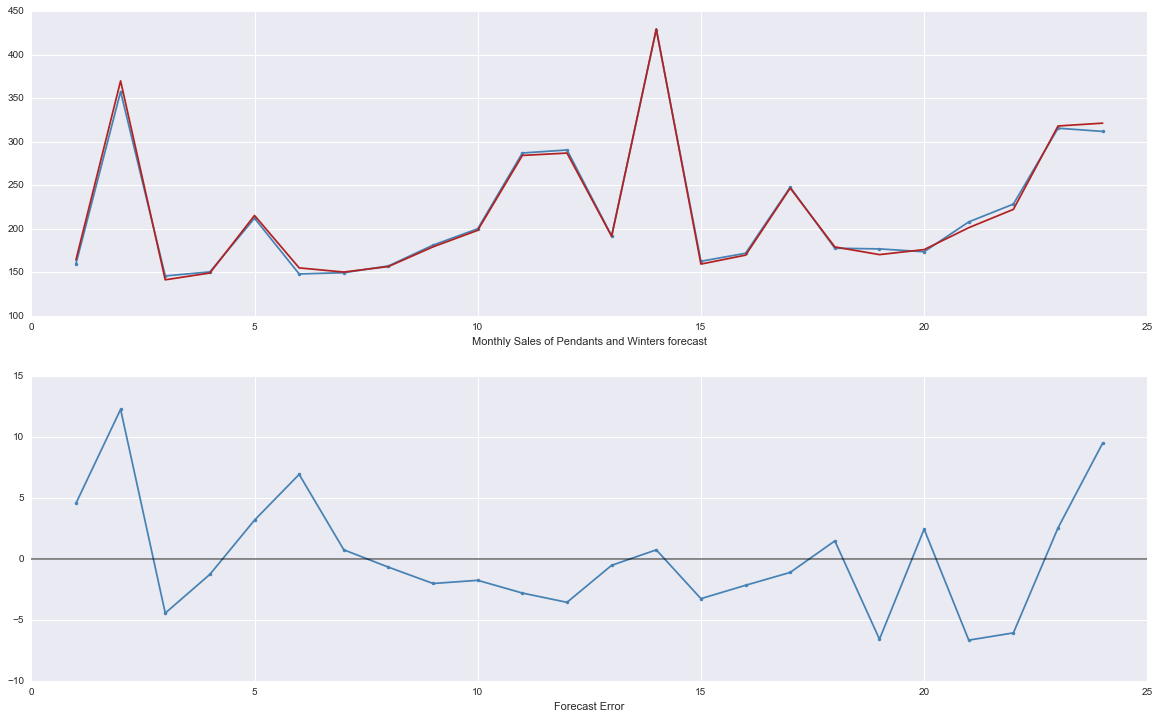

In [24]:
winters, levels, trends, factors = holt_winters_forecast(187.198931991, 2.4533, results[0][0], results[0][1], results[0][2], df["sales"], initial_seasonal_factors)
figure = plt.figure(figsize=(20, 12))

axes = figure.add_subplot(2, 1, 1)

axes.plot( df["month"], df["sales"], color="steelblue", marker=".")
axes.plot( df["month"], winters, color="firebrick")
axes.set_xlabel( "Monthly Sales of Pendants and Winters forecast")

axes = figure.add_subplot(2, 1, 2)

axes.plot( df["month"], winters - df["sales"], color="steelblue", marker=".")
axes.axhline(y=0.0, xmin=0, xmax=40, c="black", alpha=0.5)
axes.set_xlabel("Forecast Error")

plt.show()